<a href="https://colab.research.google.com/github/CBravoR/AdvancedAnalyticsLabs/blob/master/notebooks/python/Lab_9_ConvNets_for_Text_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks for Text Analytics

In this lab, we will work on convolutional networks applied to our IMDB embedding. We will test two architectures: A simple convnet using a sequence of layers, and a more complex one implementing a paper and using [Keras' Model API](https://keras.io/models/model/).

First, let's import the data as we had it last week. I saved the output using numpy's [savetxt](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.savetxt.html) and will load it with [genfromtxt](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.genfromtxt.html).

In [1]:
# Imports

%tensorflow_version 2.x

# Keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import get_file
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Others
import numpy as np
from sklearn.model_selection import train_test_split

# For AUC estimation and ROC plots
from sklearn.metrics import roc_curve, auc

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [3]:
# Get the data and unzip it.
!gdown 'https://drive.google.com/uc?id=1Yq3CkEEv0pSHlbP6eT49FIge2qpIiYoi'

# Extract the files.
!unzip IMDB_Preprocessed.zip

Downloading...
From: https://drive.google.com/uc?export=download&id=1-zwO4umZ2g0eSG5IciYCFSV-fHqP1O35
To: /content/IMDB_Preprocessed.zip
100% 35.2M/35.2M [00:00<00:00, 144MB/s]
Archive:  IMDB_Preprocessed.zip
   creating: IMDB_Preprocessed/
  inflating: IMDB_Preprocessed/IMDB_Labels.txt  
  inflating: IMDB_Preprocessed/IMDB_EmbeddingMatrix.txt  
  inflating: IMDB_Preprocessed/IMDB_Padded.txt  


In [4]:
# Read word embeddings
embedding_matrix = np.genfromtxt('IMDB_Preprocessed/IMDB_EmbeddingMatrix.txt')

# Read the padded text sequences. Uses numpy function that loads from a previously saved txt.
data = np.genfromtxt('IMDB_Preprocessed/IMDB_Padded.txt')
labels = np.genfromtxt('IMDB_Preprocessed/IMDB_Labels.txt')

We will also generate a train and test set to make a fair comparison between our models. From here onwards we will use the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from scikit-learn. This works for any general dataset, not only scorecards.



In [5]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33,
                                                    random_state=2022, 
                                                    stratify = labels)

From last week, we could build a CNN. We now will create a much more powerful structure, a convolutional neural network with parallel convolutional layers following [Kim et al. (2015)](https://arxiv.org/abs/1408.5882), to create a much better model. First let's create a sequential model for comparison.

---



## Sequential ConvNet 

We will try a very simple architecture:

1. A 1D convolution of size 3 (so three word sequences)
2. A second 1D convolution of size 3 (so more complex word sequences)
3. Dropout to avoid overfitting
4. Max pooling to get the most important sequences.
5. A flattening layer.
6. A dense layer of 128 neurons.
7. Dropout with p = 0.5
8. A softmax output.


In [6]:
# Final model.
model = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=600,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model.add(embedding_layer)

Now we add our first convolution. The operation is to add a Convolution1D layer, called [Conv1D](https://keras.io/layers/convolutional/) as we did last week, over the data.

In [7]:
model.add(Conv1D(filters=128,           # How many filters to calculate.
                 kernel_size=3,         # How many words to calculate per filter.
                 padding='valid',       # Add padding?
                 activation='relu',     # What activation to use?
                 strides=1)             # What stride to use?
         )

(if you get a warning, ignore it, it is a slight difference between Keras and Tensorflow).

We now add our second convolutional layer.

In [8]:
model.add(Conv1D(filters=128,           # How many filters to calculate.
                 kernel_size=3,         # How many words to calculate per filter.
                 padding='valid',       # Add padding?
                 activation='relu',     # What activation to use?
                 strides=1)             # What stride to use?
         )

And now we add max pooling. We will reduce filters by a factor of 3, to keep with the number. Basically, we will only choose one out of every three sequences that we are studying, the most intense one.

In [9]:
model.add(MaxPooling1D(pool_size = 3))

Now we are almost ready. First we flatten, and then add a dense layer. Dropout and an output layer finalize the problem.

In [10]:
# Flatten
model.add(Flatten())

# Dense Layer of size 128 with Dropout
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))

# Output layer of size 1
model.add(Dense(1, activation = 'sigmoid'))

That's it! Now we can check the summary of the network.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 600, 300)          5455500   
                                                                 
 conv1d (Conv1D)             (None, 598, 128)          115328    
                                                                 
 conv1d_1 (Conv1D)           (None, 596, 128)          49280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 198, 128)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 25344)             0         
                                                                 
 dense (Dense)               (None, 128)               3244160   
                                                        

As last time, we need a binary_crossentropy error function. I will use Adam for training.

In [12]:
# Use Adam as optimizer, with a binary_crossentropy error.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

Now we train! We will calculate the model over the training set, and then estimate the AUC of the model over both the training and testing set.

In [13]:
# Fit the model
model.fit(X_train, y_train, validation_split=0.33, epochs=20, batch_size=20)

Epoch 1/20
23/23 [==============================] - 11s 44ms/step - loss: 0.7270 - acc: 0.5156 - val_loss: 0.6932 - val_acc: 0.4865
Epoch 2/20
23/23 [==============================] - 1s 26ms/step - loss: 0.6927 - acc: 0.5134 - val_loss: 0.6932 - val_acc: 0.4865
Epoch 3/20
23/23 [==============================] - 1s 25ms/step - loss: 0.6935 - acc: 0.5134 - val_loss: 0.6930 - val_acc: 0.4865
Epoch 4/20
23/23 [==============================] - 0s 21ms/step - loss: 0.6889 - acc: 0.5558 - val_loss: 0.6936 - val_acc: 0.4865
Epoch 5/20
23/23 [==============================] - 0s 21ms/step - loss: 0.6868 - acc: 0.5402 - val_loss: 0.6885 - val_acc: 0.5766
Epoch 6/20
23/23 [==============================] - 1s 37ms/step - loss: 0.6666 - acc: 0.6540 - val_loss: 0.6799 - val_acc: 0.5270
Epoch 7/20
23/23 [==============================] - 1s 33ms/step - loss: 0.6143 - acc: 0.6429 - val_loss: 0.6015 - val_acc: 0.7162
Epoch 8/20
23/23 [==============================] - 1s 34ms/step - loss: 0.4858 - 

The model reaches 100% predictive capability very quickly in the train set, but the validation set overadjust quite quickly too! You should play around with your architectures until you are happy with one that represents correctly the variability of the data.

The following code shows the training history.

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


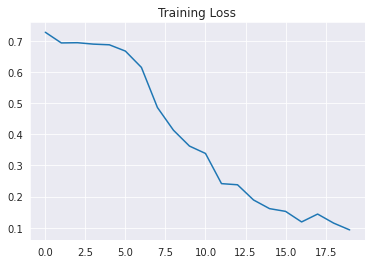

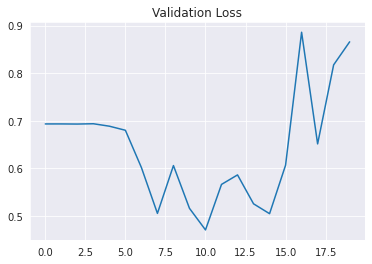

In [14]:
# Plot history

print(model.history.history.keys())

sns.set_style("darkgrid")
plt.plot(model.history.history['loss'])
plt.title('Training Loss')

plt.show()

sns.set_style("darkgrid")
plt.plot(model.history.history['val_loss'])
plt.title('Validation Loss')

plt.show()

We should have probably stopped training at around 6 epochs or so. It's possible to do this automatically, you need to add a [callback](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/). Read the link for a tutorial. You must either do it manually or automatically, but you **must** do it.

We can now calculate the ROC curve of the model with the following code.

In [15]:
# Calculate outputs in test set
prob_test = model.predict(X_test, verbose = 1)
prob_train = model.predict(X_train, verbose = 1)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_train, prob_train)
roc_auc = auc(fpr, tpr)
print('\nAUC train: ', roc_auc)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, prob_test)
roc_auc = auc(fpr, tpr)
print('AUC test: ', roc_auc)

21/21 [==============================] - 0s 13ms/step

AUC train:  0.9742748941857875
AUC test:  0.8804407713498622


Not a bad model at all! This model can actually be improved much further, by carefully designing an architecture that exploits the structure of the words and the complexity of the dataset.

Let's finally plot the ROC curve over the test set.

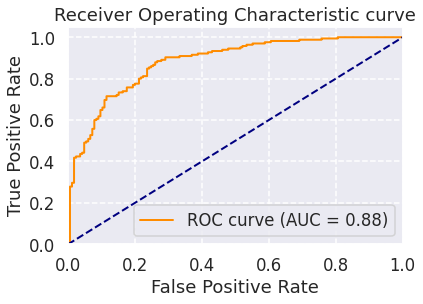

In [16]:
sns.set('talk', 'darkgrid', 'dark', font_scale=1, \
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")

# I am saving the output as a PDF for easy exporting.
plt.savefig('roc_auc.pdf', format = "pdf")

# Now I show the plot inline.
plt.show()

## Keras Model API

As we saw in the lectures, Google's LeNet showed that stacking parallel layers of convolution (so, not sequential models) seemed like a good idea. This principle was captured by [Kim et al. (2015)](https://arxiv.org/abs/1408.5882) to create an architecture using multiple filters of different lengths, before a final dense layer. There are no stacked convolutions here.

Which one performs better? Let's see. The plot of this architecture follows.

![](https://drive.google.com/uc?export=view&id=1W41RmVNWLPHSSm0gR9yEzVPBpyZJ3ym7)

Having parallel layers is the opossite of having a sequential model, so we need to use the excellent [Model API](https://keras.io/models/model/) of Keras, which will allow us to get as creative as we want with our models.

Our architecture now is as follows:

1. An embedding layer, just like before.
2. A parallel model of four layers, each consisting of:
    - A Conv1D layer with kernel sizes [2, 3, 4, 6] (arbitrary, play around with this), with 128 filters (also arbitrary).
    - A max pooling layer of size Embedding Dimension - Filter Size + 1. Basically get just the best feature per filter.
    - A flattening layer to turn this into a vector.
3. A dense layer of size 128.
4. Dropout with probability 0.5.
5. An output layer of size 1.

The authors discuss that this model will have a much better capacity to study complex structures without overfitting. One critique of the model is that you are only looking at n-grams without focusing on complex combined structures.

So, let's start by creating the stacked structure. Given that these go in parallel, we need to create the structure Conv1D - MaxPool - Flattening, and then append them into an object. Finally, the special [Concatenate](https://keras.io/layers/merge/#concatenate) layer is the one that puts them in parallel next to each other.

The following codes does this at once for all filter sizes.

In [17]:
# Filter sizes to use.
filter_sizes = (2,3,4,6)

# Initialize. We need to give it the input dimension (from the Embedding!)
graph_in = Input(shape=(600, 300))
convs = []
avgs = []

# This for stacks the layers. Inside each for, we build the sequence of layer. The command "append" adds
# that to the "conv" variable, which is simply a stack of convolutions.
for fsz in filter_sizes:
    conv = Conv1D(filters=128,
                  kernel_size=fsz,
                         padding='valid',
                         activation='relu',
                         strides=1)(graph_in) # Note the (graph_in). This means "put this layer AFTER the graph_in layer.
    pool = MaxPooling1D(pool_size=600 - fsz + 1)(conv) # Put this layer AFTER the convolution just created.
    flattenMax = Flatten()(pool) # Flatten the pooling layer.
    convs.append(flattenMax) # Append this to the convs object that saves the stack.
    
# Concatenate layers.
if len(filter_sizes)>1:
    out = Concatenate()(convs)
else:
    out = convs[0]

graph = Model(inputs=graph_in, outputs=out, name="graphModel")

graph.summary()

Model: "graphModel"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 300)]   0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 599, 128)     76928       ['input_1[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 598, 128)     115328      ['input_1[0][0]']                
                                                                                                  
 conv1d_4 (Conv1D)              (None, 597, 128)     153728      ['input_1[0][0]']                
                                                                                         

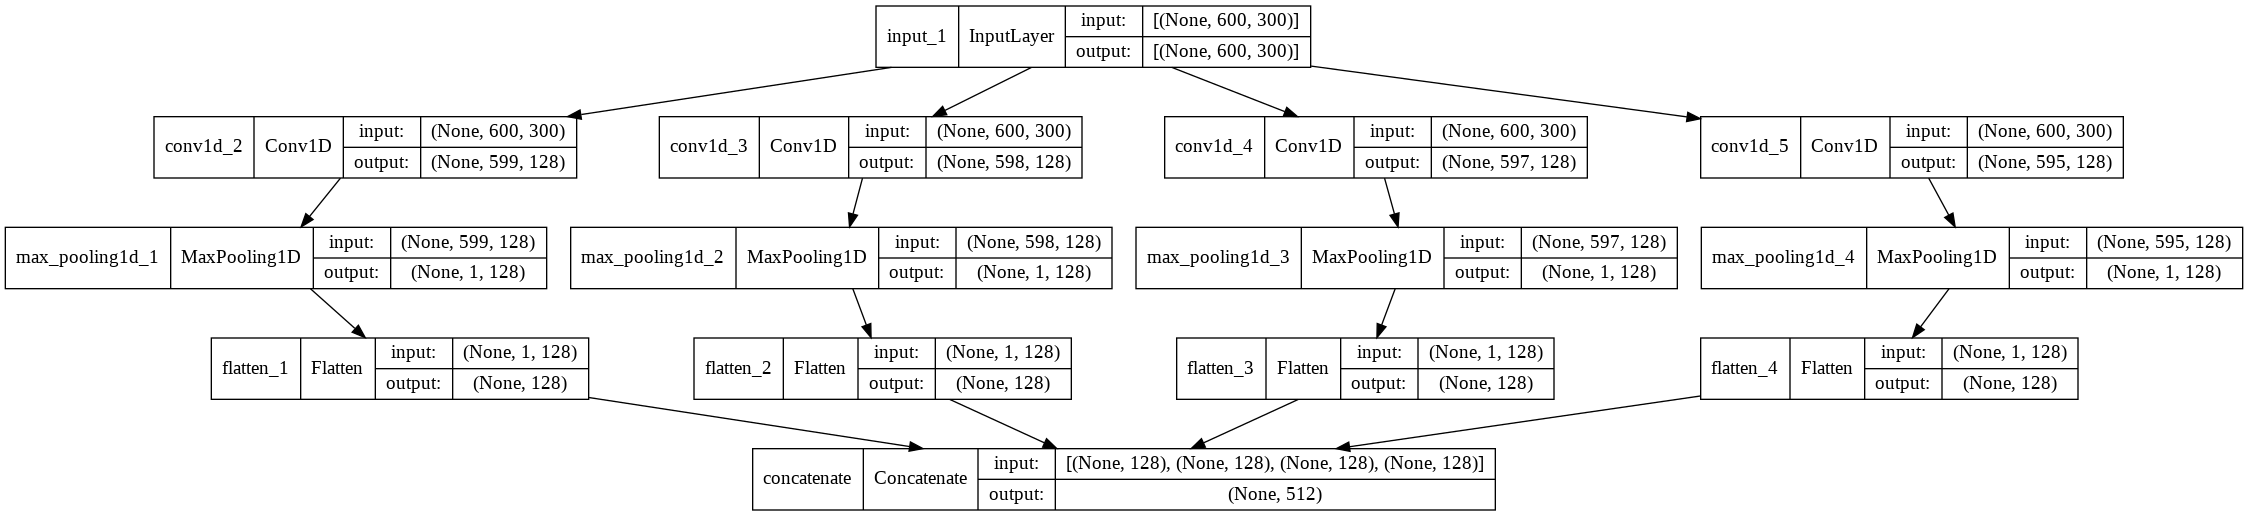

In [18]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image
%matplotlib inline

plot_model(graph, show_shapes=True, show_layer_names=True, to_file='GraphModel.png')
Image(retina=True, filename='GraphModel.png')

Note that we named the model "graphModel", and that it follows the architecture we discussed. This is just the "middle" part of the network, so we need to add an input layer, and an output layer.

We can do this with a traditional sequential model.

In [19]:
# Final model
model = Sequential()
embedding_layer = Embedding(len(embedding_matrix),           # Words in the embedding.
                            300,                           # Embedding dimension
                            weights=[embedding_matrix],    # The weights we just calculated
                            input_length=600,              # The maximum number of words.
                            trainable=False)               # To NOT recalculate weights!

model.add(embedding_layer)

# Now we add our graph model
model.add(graph)

# Add a few layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# adam = Adam(clipnorm=.1)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 600, 300)          5455500   
                                                                 
 graphModel (Functional)     (None, 512)               576512    
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,097,805
Trainable params: 642,305
Non-trainable params: 5,455,500
_________________________________________________________________


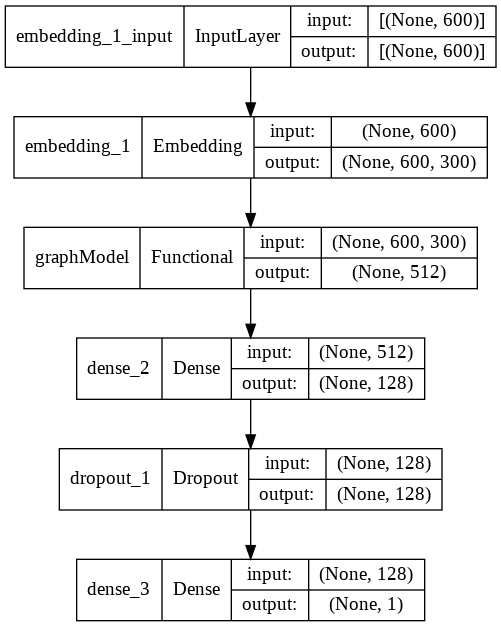

In [21]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image
%matplotlib inline

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

The summary shows what we expected: The graph model is thought to be just one more layer of our main sequential model. This allow us to train very complex models! An example would be Google's LeNet (see example [here](https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9)). The goal is simply to build the basic building blocks independently and stack those.

Let's train our model. Now the code is the same as before.

In [22]:
# Fit the model
model.fit(X_train, y_train, validation_split=0.33, epochs=20, batch_size=20)

Epoch 1/20
23/23 [==============================] - 5s 110ms/step - loss: 0.7320 - acc: 0.5223 - val_loss: 0.7028 - val_acc: 0.5135
Epoch 2/20
23/23 [==============================] - 2s 75ms/step - loss: 0.6697 - acc: 0.6004 - val_loss: 0.6707 - val_acc: 0.5495
Epoch 3/20
23/23 [==============================] - 2s 74ms/step - loss: 0.6089 - acc: 0.7746 - val_loss: 0.6419 - val_acc: 0.7748
Epoch 4/20
23/23 [==============================] - 2s 73ms/step - loss: 0.4994 - acc: 0.8817 - val_loss: 0.6020 - val_acc: 0.6757
Epoch 5/20
23/23 [==============================] - 2s 74ms/step - loss: 0.3759 - acc: 0.9375 - val_loss: 0.5252 - val_acc: 0.7748
Epoch 6/20
23/23 [==============================] - 2s 74ms/step - loss: 0.2313 - acc: 0.9576 - val_loss: 0.6470 - val_acc: 0.5991
Epoch 7/20
23/23 [==============================] - 2s 74ms/step - loss: 0.1328 - acc: 0.9933 - val_loss: 0.4402 - val_acc: 0.7883
Epoch 8/20
23/23 [==============================] - 2s 73ms/step - loss: 0.0625 - 

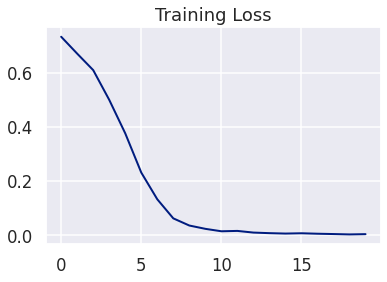

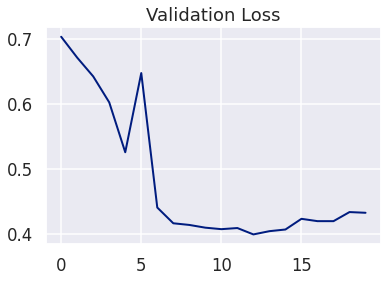

In [23]:
# Plot history
sns.set_style("darkgrid")
plt.plot(model.history.history['loss'])
plt.title('Training Loss')

plt.show()

sns.set_style("darkgrid")
plt.plot(model.history.history['val_loss'])
plt.title('Validation Loss')

plt.show()

Would you stop training? If so, where?

Let's plot the ROC curve.

21/21 [==============================] - 1s 26ms/step

AUC train:  0.98874582312319
AUC test:  0.9353168044077135


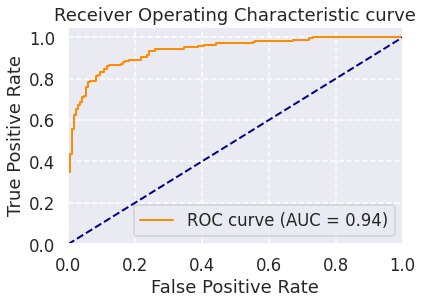

In [24]:
# Calculate outputs in test set
prob_test = model.predict(X_test, verbose = 1)
prob_train = model.predict(X_train, verbose = 1)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_train, prob_train)
roc_auc = auc(fpr, tpr)
print('\nAUC train: ', roc_auc)

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, prob_test)
roc_auc = auc(fpr, tpr)
print('AUC test: ', roc_auc)

sns.set('talk', 'darkgrid', 'dark', font_scale=1, \
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

lw = 2
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.savefig('roc_auc.pdf', format = "pdf")
plt.show()

Now we are getting impressive results! This is the power of a well trained neural network. This is already reaching close to state-of-the-art accuracies.

## Self-study

The state of the art methods can reach around 0.9-0.95 AUC. Can you improve upon these results?